# Image classification using neural networks (pytorch) on data from [kaggle](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

## 1. Loading data 

In [1]:
from pathlib import Path
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "images"

In [2]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/images/train'), WindowsPath('data/images/test'))

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
#Transforming the data to be used in a pytorch neurak
data_transform = transforms.Compose([
    transforms.Resize((64,64)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

In [4]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 14034
     Root location: data\images\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 3000
     Root location: data\images\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [6]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

## 2. Exploring the data

In [38]:
import random
from PIL import Image
import matplotlib.pyplot as plt

### 2.1 Plotting some images

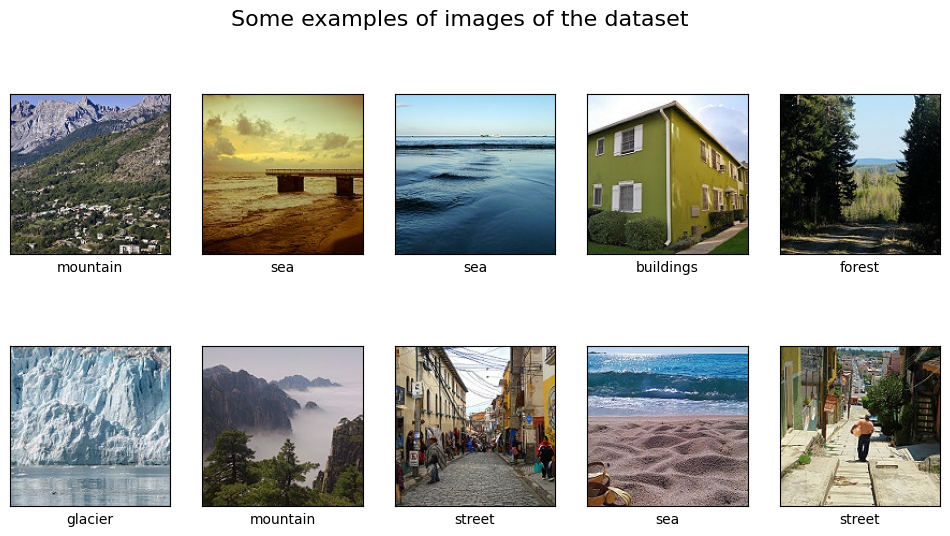

In [44]:
# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))
fig = plt.figure(figsize=(12,6))
fig.suptitle("Some examples of images of the dataset", fontsize=16)
for i in range(10):
    # 2. Get random image path
    random_image_path = random.choice(image_path_list)

    # 3. Get image class from path name (the image class is the name of the directory where the image is stored)
    image_class = random_image_path.parent.stem

    # 4. Open image
    img = Image.open(random_image_path) 
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(image_class)
plt.show()

### 2.2 Class distribution plot

In [88]:
from collections import Counter
train_distribution = dict(Counter(train_data.targets))
test_distribution = dict(Counter(test_data.targets))

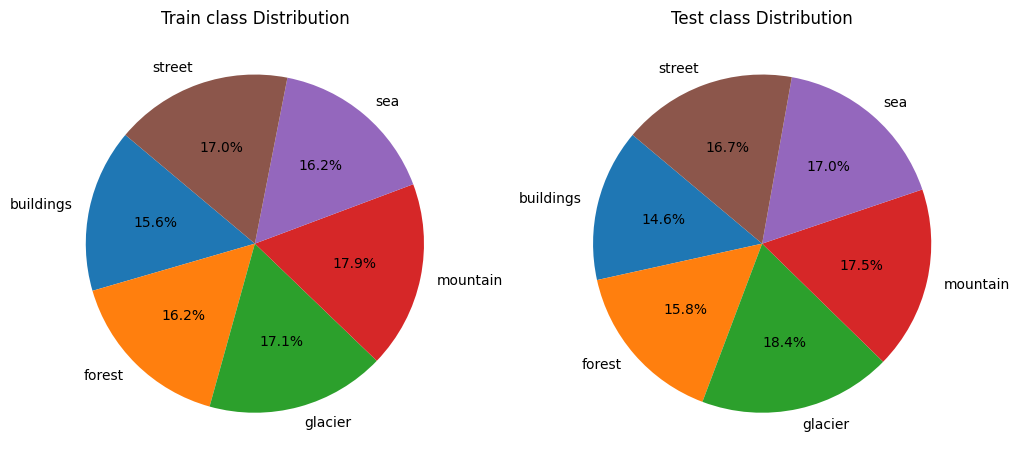

In [94]:
plt.figure(figsize=(12, 10))
plt.subplot(1,2,1)
plt.pie(train_distribution.values(), labels=train_data.classes, autopct='%1.1f%%', startangle=140)
plt.title('Train class Distribution')
plt.subplot(1,2,2)
plt.pie(test_distribution.values(), labels=train_data.classes, autopct='%1.1f%%', startangle=140)
plt.title('Test class Distribution')
plt.show()

### 3. Transforming data

## MODEL

In [100]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=10,kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=10,out_channels=10,kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2, padding=0)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10,out_channels=10,kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=10,out_channels=10,kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2, padding=0)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=10*13*13,
                      out_features=6),
            nn.Softmax(dim=1)
                      )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.classifier(x)
        return x

In [101]:
torch.manual_seed(42)
model_0 = CNN()
model_0

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=6, bias=True)
    (2): Softmax(dim=1)
  )
)

In [115]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [116]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [121]:
num_epochs = 5

for epoch in range(num_epochs):
    model_0.train() # Set the model to training mode
    train_loss, train_acc = 0, 0

    for batch_idx, (X,y) in enumerate(train_loader):

        y_pred = model_0(X)  # Forward pass

        loss = loss_fn(y_pred, y)  # Compute the loss
        train_loss += loss
        train_acc += accuracy_fn(y,y_pred.argmax(dim=1)) #calculate acc
        
        optimizer.zero_grad()  # Zero the gradients
        
        loss.backward()  # Backpropagation

        optimizer.step()  # Update the weights
        
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")


    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

test_loss, test_acc = 0, 0
model_0.eval()
with torch.inference_mode(): 
    for X, y in test_loader:
        
        test_pred = model_0(X) # Forward pass

        test_loss = loss_fn(test_pred, y) # Calculate loss and accuracy
        test_acc += accuracy_fn(y,test_pred.argmax(dim=1))

    # Adjust metrics and print out
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

Epoch [1/5], Batch [1/439], Loss: 1.1948
Epoch [1/5], Batch [101/439], Loss: 1.2572
Epoch [1/5], Batch [201/439], Loss: 1.2369
Epoch [1/5], Batch [301/439], Loss: 1.2896
Epoch [1/5], Batch [401/439], Loss: 1.2670
Train loss: 1.32131 | Train accuracy: 72.22%
Epoch [2/5], Batch [1/439], Loss: 1.2954
Epoch [2/5], Batch [101/439], Loss: 1.4228
Epoch [2/5], Batch [201/439], Loss: 1.3195
Epoch [2/5], Batch [301/439], Loss: 1.3650
Epoch [2/5], Batch [401/439], Loss: 1.1866
Train loss: 1.31458 | Train accuracy: 72.95%
Epoch [3/5], Batch [1/439], Loss: 1.2303
Epoch [3/5], Batch [101/439], Loss: 1.3761
Epoch [3/5], Batch [201/439], Loss: 1.3100
Epoch [3/5], Batch [301/439], Loss: 1.3474
Epoch [3/5], Batch [401/439], Loss: 1.2750
Train loss: 1.30379 | Train accuracy: 74.06%
Epoch [4/5], Batch [1/439], Loss: 1.3656
Epoch [4/5], Batch [101/439], Loss: 1.1617
Epoch [4/5], Batch [201/439], Loss: 1.4018
Epoch [4/5], Batch [301/439], Loss: 1.2428
Epoch [4/5], Batch [401/439], Loss: 1.1915
Train loss: 1